# **Data For Police Arrests and Police Facilities**


Police Facility Count by Police Zone:
  police_zone  police_station_count
0         5.0                     6
1         2.0                     5
2         1.0                     4
3         6.0                     1
4         3.0                     1
5         4.0                     1

Arrest Count by Neighborhood:
                neighborhood  arrest_count
0  central business district          4440
1           south side flats          3497
2                        nan          2489
3                    carrick          2352
4             east allegheny          2217

Arrest Data with Mapped Police Zone (first 10 rows):
                 neighborhood  arrest_count police_zone
0   central business district          4440         2.0
1            south side flats          3497         3.0
3                     carrick          2352         3.0
4              east allegheny          2217         1.0
5              homewood south          2090         5.0
6              homewood north 

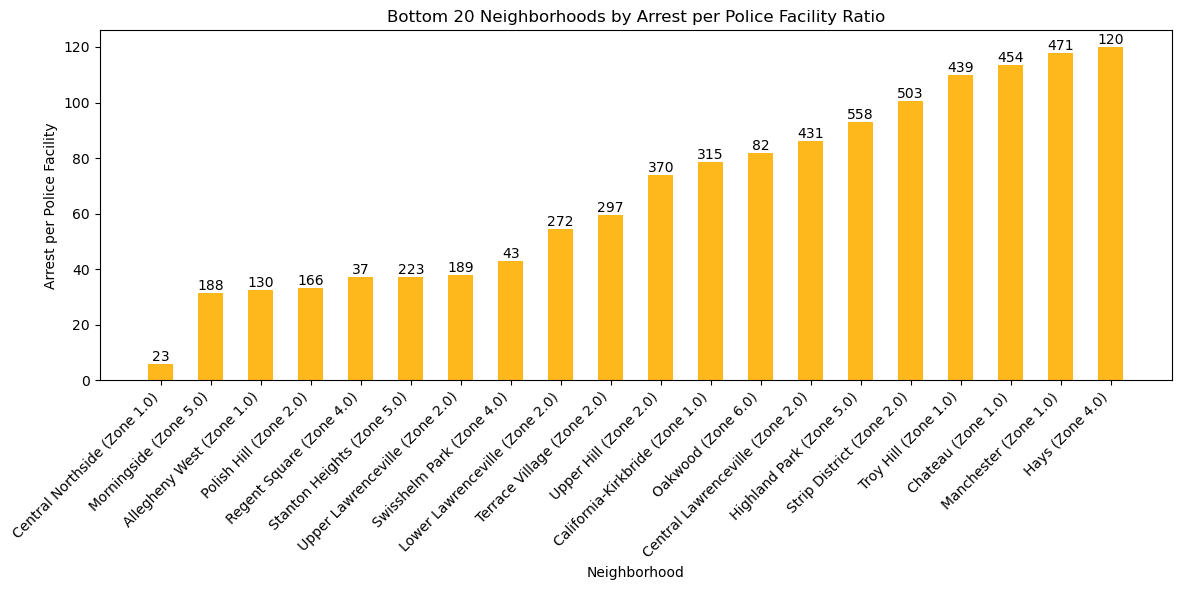

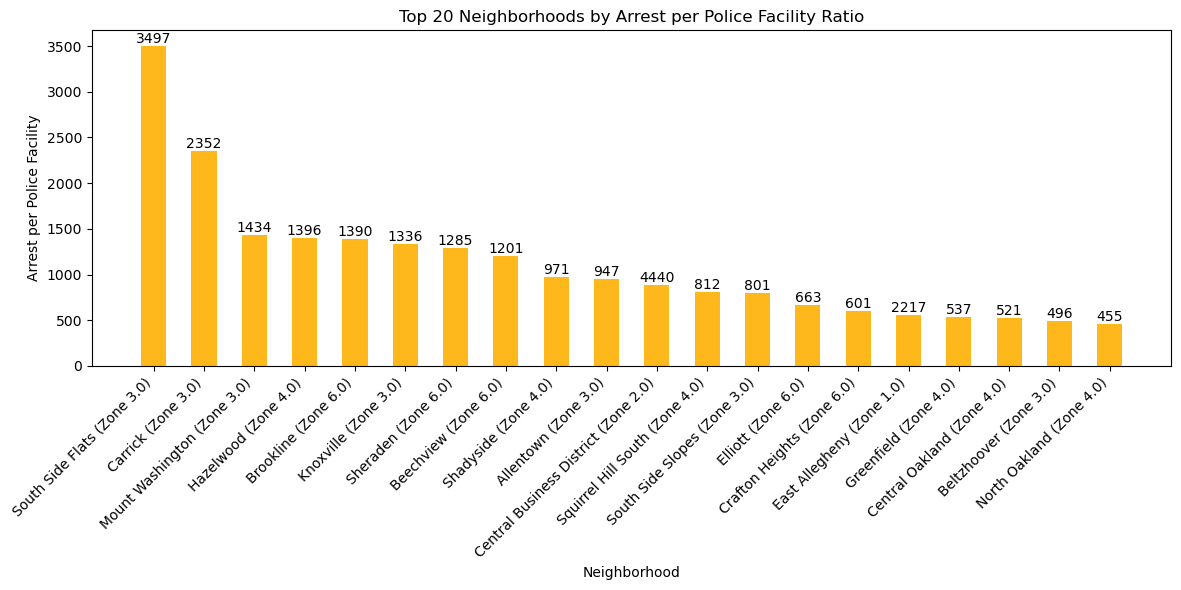

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Step 1: Load City Facilities Data and Create Neighborhood-to-PoliceZone Mapping
# ------------------------------

# Read the City Facilities CSV
facilities_df = pd.read_csv("City Facilities.csv")

# Create a mapping from neighborhood to police zone
mapping_df = facilities_df[['neighborhood', 'police_zone']].dropna().drop_duplicates(subset=['neighborhood'])

# Clean up the data
mapping_df['neighborhood'] = mapping_df['neighborhood'].astype(str).str.strip().str.lower()
mapping_df['police_zone'] = mapping_df['police_zone'].astype(str).str.strip().str.lower()

# Create the mapping dictionary
neighborhood_to_zone = mapping_df.set_index('neighborhood')['police_zone'].to_dict()

# Filter rows for police facilities
police_facilities = facilities_df[facilities_df["name"].str.contains("police", case=False, na=False)].copy()
police_facilities['police_zone'] = police_facilities['police_zone'].astype(str).str.strip().str.lower()

# Group by police_zone
police_station_counts = police_facilities["police_zone"].value_counts().reset_index()
police_station_counts.columns = ["police_zone", "police_station_count"]
print("\nPolice Facility Count by Police Zone:")
print(police_station_counts)

# ------------------------------
# Step 2: Load Police Arrest Data and Aggregate by Neighborhood
# ------------------------------

arrest_df = pd.read_csv("Police Arrest Data.csv")
arrest_df['INCIDENTNEIGHBORHOOD'] = arrest_df['INCIDENTNEIGHBORHOOD'].astype(str).str.strip().str.lower()

arrest_by_neighborhood = arrest_df['INCIDENTNEIGHBORHOOD'].value_counts().reset_index()
arrest_by_neighborhood.columns = ["neighborhood", "arrest_count"]
print("\nArrest Count by Neighborhood:")
print(arrest_by_neighborhood.head())

# ------------------------------
# Step 3: Map Each Neighborhood to Police Zone and Merge with Facility Counts
# ------------------------------

arrest_by_neighborhood['police_zone'] = arrest_by_neighborhood['neighborhood'].map(neighborhood_to_zone)
arrest_by_neighborhood = arrest_by_neighborhood.dropna(subset=['police_zone'])
arrest_by_neighborhood['police_zone'] = arrest_by_neighborhood['police_zone'].astype(str).str.strip().str.lower()

print("\nArrest Data with Mapped Police Zone (first 10 rows):")
print(arrest_by_neighborhood.head(10))

merged_neighborhood = pd.merge(arrest_by_neighborhood, police_station_counts,
                               left_on='police_zone', right_on='police_zone', how='inner')

merged_neighborhood['arrest_per_station'] = merged_neighborhood['arrest_count'] / merged_neighborhood['police_station_count']

print("\nMerged Data (by Neighborhood):")
print(merged_neighborhood)

# ------------------------------
# Step 4: Visualization (Last 20 Neighborhoods by Arrest per Police Facility)
# ------------------------------

# Get the 20 neighborhoods with the lowest arrest per station ratio
bottom20 = merged_neighborhood.sort_values("arrest_per_station", ascending=True).head(20)
x = np.arange(len(bottom20))
bar_width = 0.5

plt.figure(figsize=(12, 6))
bars = plt.bar(x, bottom20["arrest_per_station"], width=bar_width, color='#FFB81C')

plt.xlabel("Neighborhood")
plt.ylabel("Arrest per Police Facility")
plt.title("Bottom 20 Neighborhoods by Arrest per Police Facility Ratio")

labels = [f"{row['neighborhood'].title()} (Zone {row['police_zone'].upper()})" for _, row in bottom20.iterrows()]
plt.xticks(x, labels, rotation=45, ha="right")

for i, bar in enumerate(bars):
    height = bar.get_height()
    abs_arrest = int(bottom20["arrest_count"].iloc[i])
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{abs_arrest}", ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# Sort by Arrest_per_station in descending order and take the top 10 neighborhoods
top20 = merged_neighborhood.sort_values("arrest_per_station", ascending=False).head(20)
x = np.arange(len(top20))
bar_width = 0.5  # Adjusted bar width for spacing

plt.figure(figsize=(12, 6))
bars = plt.bar(x, top20["arrest_per_station"], width=bar_width, color='#FFB81C')

plt.xlabel("Neighborhood")
plt.ylabel("Arrest per Police Facility")
plt.title("Top 20 Neighborhoods by Arrest per Police Facility Ratio")
# Create x-axis labels with neighborhood name and corresponding zone info, e.g., "South Side Flats (Zone 3)"
labels = [f"{row['neighborhood'].title()} (Zone {row['police_zone'].upper()})" for _, row in top20.iterrows()]
plt.xticks(x, labels, rotation=45, ha="right")

# Annotate each bar with the absolute arrest count
for i, bar in enumerate(bars):
    height = bar.get_height()
    abs_arrest = int(top20["arrest_count"].iloc[i])
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{abs_arrest}", ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()